In [1]:
import pandas as pd
import json
import requests
from pymongo import MongoClient
import matplotlib.pyplot as plt
import psycopg2
import folium
from folium.plugins import MarkerCluster

# API link for GreenJobs data
api_link_greenjobs = 'https://data.ny.gov/resource/9evn-drxk.json'

# Fetching data from API
response = requests.get(api_link_greenjobs)

if response.status_code == 200:
    data = response.json()
    greenjobs_df = pd.DataFrame(data)
else:
    print(f"Failed to fetch data from API at {api_link_greenjobs}.")
    
# Connecting to MongoDB
client = MongoClient('localhost', 27017)  # Assuming MongoDB is running on localhost:27017
db = client['mydb']  # Create or connect to the 'greenjobs_db' database
collection = db['greenjobs_collection']  # Create or connect to the 'greenjobs_collection' collection

# Converting DataFrame to dictionary and insert into MongoDB
data_dict = greenjobs_df.to_dict(orient='records')
collection.insert_many(data_dict)

print("Data inserted into MongoDB successfully.")

# Displaying the first few rows of GreenJobs DataFrame
print("First few rows of GreenJobs DataFrame:")
print(greenjobs_df.head())
print(greenjobs_df.info())
print(greenjobs_df.columns)

Data inserted into MongoDB successfully.
First few rows of GreenJobs DataFrame:
          reporting_period            contract_date               setup_date  \
0  2024-03-31T00:00:00.000  2020-11-03T00:00:00.000  2020-11-03T00:00:00.000   
1  2024-03-31T00:00:00.000  2012-06-29T00:00:00.000  2012-06-29T00:00:00.000   
2  2024-03-31T00:00:00.000  2017-02-07T00:00:00.000  2017-02-07T00:00:00.000   
3  2024-03-31T00:00:00.000  2013-06-25T00:00:00.000  2013-06-25T00:00:00.000   
4  2024-03-31T00:00:00.000  2021-10-14T00:00:00.000  2021-10-14T00:00:00.000   

  original_loan_amount original_term   original_maturity_date  \
0                 9150           180  2035-11-03T00:00:00.000   
1               7156.5           180  2027-06-29T00:00:00.000   
2                17657           180  2032-02-09T00:00:00.000   
3             10683.52           103  2028-06-25T00:00:00.000   
4               8678.1           164  2036-10-13T00:00:00.000   

     current_maturity_date interest_rate credit_


Visualization for GreenJobs DataFrame:


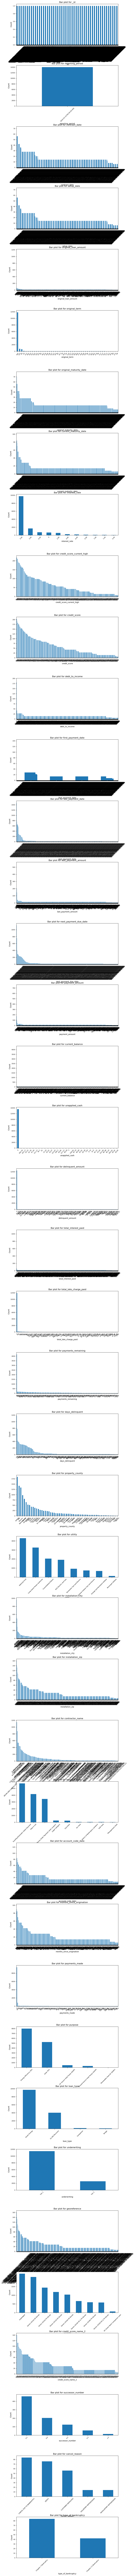

In [4]:
# Fetching data from MongoDB and convert it to a DataFrame
cursor = collection.find({})
greenjobs_df = pd.DataFrame(list(cursor))

# Visualizing GreenJobs DataFrame
print("\nVisualization for GreenJobs DataFrame:")

# Checking data types
numeric_cols = greenjobs_df.select_dtypes(include=['number']).columns
categorical_cols = greenjobs_df.select_dtypes(include=['object']).columns

# Calculating figure size based on number of columns
num_cols = len(numeric_cols) + len(categorical_cols)
figsize = (10, 6 * num_cols)  # Adjust height based on the number of columns

# Seting figure size and layout
plt.figure(figsize=figsize)

# Ploting histograms for numerical columns
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(num_cols, 1, i)
    greenjobs_df[col].hist()
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tick_params(axis='both', which='major', labelsize=8)  # Shorten font size

# Ploting bar plots for categorical columns
for i, col in enumerate(categorical_cols, len(numeric_cols) + 1):
    plt.subplot(num_cols, 1, i)
    greenjobs_df[col].value_counts().plot(kind='bar')
    plt.title(f'Bar plot for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tick_params(axis='both', which='major', labelsize=8)  # Shorten font size

# Adjusting spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show plots
plt.show()

In [2]:
# Preprocessing steps
# Iterating through each row and convert georeference of GreenJobs to WKT format
for index, row in greenjobs_df.iterrows():
    georeference = row['georeference']
    longitude, latitude = georeference['coordinates']
    wkt_point = f'POINT ({longitude} {latitude})'
    greenjobs_df.at[index, 'wkt_georeference'] = wkt_point

# Droping the original georeference column
greenjobs_df.drop(columns=['georeference'], inplace=True)

# Specifying the list of columns to be removed from GreenJobs DataFrame
columns_to_remove_Greenjobs = ['successor_number', 'credit_score_name_2', 'cancel_reason', 'type_of_bankruptcy', 'reporting_period'
                              , 'reporting_period', 'setup_date', 'original_maturity_date', 'current_maturity_date', 'contractor_name'
                              , 'account_code', 'account_code_date', 'underwriting' , 'pledged']

# Checking if the specified columns exist in GreenJobs DataFrame
if all(column in greenjobs_df.columns for column in columns_to_remove_Greenjobs):
    # Drop the specified columns from GreenJobs DataFrame
    greenjobs_df.drop(columns=columns_to_remove_Greenjobs, inplace=True)
    print("Columns dropped successfully from the GreenJobs DataFrame.")
    print(greenjobs_df.columns)
    print(greenjobs_df.info())
else:
    print("Either the GreenJobs DataFrame does not exist or the specified columns do not exist.")


# Displaying the cleaned GreenJobs DataFrame
print("First few rows of cleaned GreenJobs DataFrame:")
print(greenjobs_df.head())

Columns dropped successfully from the GreenJobs DataFrame.
Index(['contract_date', 'original_loan_amount', 'original_term',
       'interest_rate', 'credit_score_current_high', 'credit_score',
       'debt_to_income', 'first_payment_date', 'last_payment_date',
       'last_payment_amount', 'next_payment_due_date', 'payment_amount',
       'current_balance', 'unapplied_cash', 'delinquent_amount',
       'total_interest_paid', 'total_late_charge_paid', 'payments_remaining',
       'days_delinquent', 'property_county', 'utility', 'installation_city',
       'installation_zip', 'months_since_origination', 'payments_made',
       'purpose', 'loan_type', 'wkt_georeference'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   contract_date              1000 non-null   object
 1   original_loan_amount    

In [3]:
# Cleaning the data for GreenJobs DataFrame
print("Cleaning GreenJobs DataFrame...")

# Replace empty strings with NaN values
greenjobs_df.replace('', float('nan'), inplace=True)

# Remove duplicate values
greenjobs_df.drop_duplicates(inplace=True)

# Remove rows with null values
greenjobs_df.dropna(inplace=True)

print("GreenJobs DataFrame cleaned.")

#  summary information of the cleaned DataFrame
print("Summary information of the cleaned GreenJobs DataFrame:")
print(greenjobs_df.info())

#  summary statistics of the cleaned DataFrame
print("\nSummary statistics of the cleaned GreenJobs DataFrame:")
print(greenjobs_df.describe())

#  first few rows of the cleaned DataFrame
print("First few rows of cleaned GreenJobs DataFrame:")
print(greenjobs_df.head())
print(greenjobs_df.columns)

Cleaning GreenJobs DataFrame...
GreenJobs DataFrame cleaned.
Summary information of the cleaned GreenJobs DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 937 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   contract_date              937 non-null    object
 1   original_loan_amount       937 non-null    object
 2   original_term              937 non-null    object
 3   interest_rate              937 non-null    object
 4   credit_score_current_high  937 non-null    object
 5   credit_score               937 non-null    object
 6   debt_to_income             937 non-null    object
 7   first_payment_date         937 non-null    object
 8   last_payment_date          937 non-null    object
 9   last_payment_amount        937 non-null    object
 10  next_payment_due_date      937 non-null    object
 11  payment_amount             937 non-null    object
 12  current_

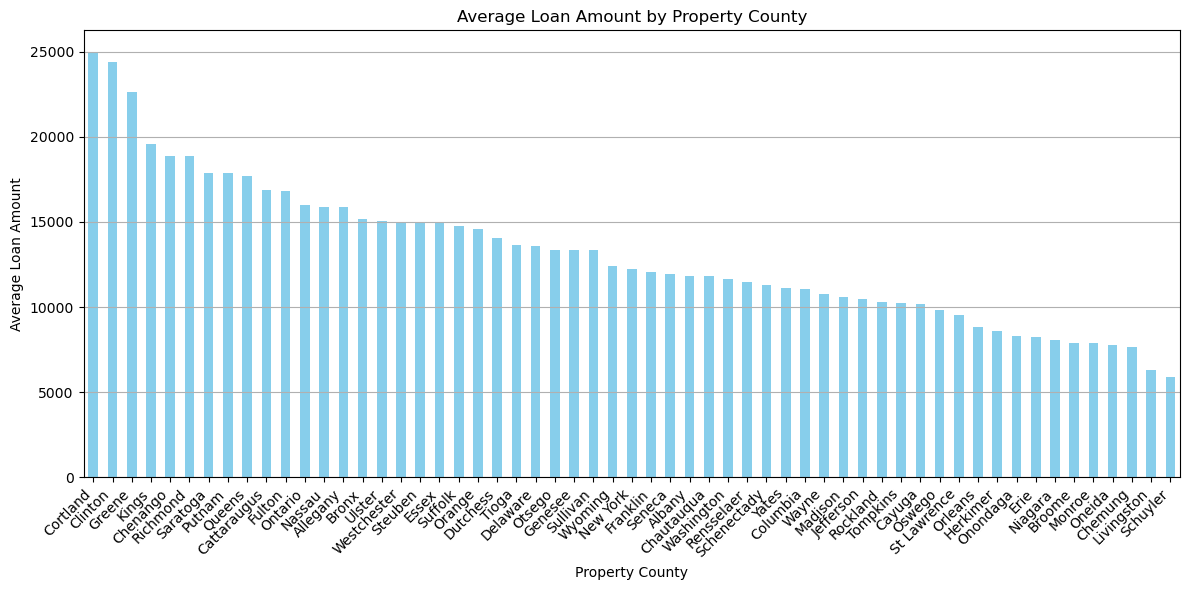

In [7]:
import matplotlib.pyplot as plt

# Converting 'original_loan_amount' column to numeric (if it contains non-numeric values)
greenjobs_df['original_loan_amount'] = pd.to_numeric(greenjobs_df['original_loan_amount'], errors='coerce')

# Grouping the data by 'property_county' and calculating the average loan amount for each county
county_avg_loan = greenjobs_df.groupby('property_county')['original_loan_amount'].mean()

# Sorting the counties based on average loan amount (optional)
county_avg_loan = county_avg_loan.sort_values(ascending=False)

# Plotting the bar plot
plt.figure(figsize=(12, 6))
county_avg_loan.plot(kind='bar', color='skyblue')
plt.title('Average Loan Amount by Property County')
plt.xlabel('Property County')
plt.ylabel('Average Loan Amount')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Function to create a new PostgreSQL database
def create_database(db_name, username, password):
    conn = None
    cur = None
    try:
        # Connect to PostgreSQL server with autocommit mode set to True
        conn = psycopg2.connect(
            host="localhost",
            user=username,
            password=password,
        )
        
        # Set autocommit mode to True
        conn.set_session(autocommit=True)
        
        # Create a cursor
        cur = conn.cursor()
        
        # Execute the CREATE DATABASE statement
        cur.execute(f"CREATE DATABASE {db_name};")
        
        print(f"Database '{db_name}' created successfully.")
    except psycopg2.Error as e:
        print(e)
    finally:
        # Close the cursor and connection
        if cur:
            cur.close()
        if conn:
            conn.close()

# Creating the new database
create_database('dapca2', 'postgres', 'postgres')


In [4]:
# Connecting to PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    database="dapca2",
    user="postgres",
    password="postgres"
)

# Creating a cursor
cur = conn.cursor()

# Creating table dynamically using DataFrame columns
columns = greenjobs_df.columns
column_definitions = ', '.join([f"{col} TEXT" for col in columns])  # Assuming all columns are of type TEXT
create_table_query = f"""
    CREATE TABLE IF NOT EXISTS greenjobs (
        id SERIAL PRIMARY KEY,
        {column_definitions}
    );
"""

# Creating table if not exists
cur.execute(create_table_query)

# Committing the table creation
conn.commit()

# Iterate through the DataFrame and insert data into PostgreSQL table
for index, row in greenjobs_df.iterrows():
    cur.execute(f"""
        INSERT INTO greenjobs ({', '.join(columns)})
        VALUES ({', '.join(['%s'] * len(columns))});
    """, tuple(row))

# Commit 
conn.commit()

# Close the cursor and connection
cur.close()
conn.close()

print("Data inserted into PostgreSQL successfully.")

Data inserted into PostgreSQL successfully.


In [5]:
#analysis provides a basic spatial overview of loan amounts across different counties, enabling stakeholders to visually explore the distribution of loans within the geographical regions
# Initializing the map centered around New York
map = folium.Map(location=[40.7128, -74.0060], zoom_start=7)

# Creating a MarkerCluster to group markers for better visualization
marker_cluster = MarkerCluster().add_to(map)

# Adding markers for each loan location
for index, row in greenjobs_df.iterrows():
    georeference = row['wkt_georeference']
    loan_amount = row['original_loan_amount']
    county = row['property_county']
    city = row['installation_city']
    
    #  display additional information on hover
    tooltip = f"County: {county}<br>City: {city}<br>Loan Amount: ${loan_amount}"
    
    #  WKT format to coordinates
    coordinates = [float(coord) for coord in georeference.replace('POINT (', '').replace(')', '').split()]
    
    # Adding marker to the MarkerCluster
    folium.Marker(
        location=[coordinates[1], coordinates[0]],  # Latitude, Longitude
        tooltip=tooltip
    ).add_to(marker_cluster)

# Saving the map as an HTML file
map.save('loan_distribution_map.html')

# Displaying the map
map